# 机器学习练习 3 - 多类分类

该代码涵盖了基于Python的解决方案，用于Coursera机器学习课程的第三个编程练习。 有关详细说明和方程式，请参阅[exercise text](ex3.pdf)。


代码修改并注释：黄海广，haiguang2000@qq.com

对于此练习，我们将使用逻辑回归来识别手写数字（0到9）。 我们将扩展我们在练习2中写的逻辑回归的实现，并将其应用于一对一的分类。 让我们开始加载数据集。 它是在MATLAB的本机格式，所以要加载它在Python，我们需要使用一个SciPy工具。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat

In [2]:
data = loadmat('ex3data1.mat')
print(data)
data['X'].shape, data['y'].shape

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011', '__version__': '1.0', '__globals__': [], 'X': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 'y': array([[10],
       [10],
       [10],
       ...,
       [ 9],
       [ 9],
       [ 9]], dtype=uint8)}


((5000, 400), (5000, 1))

好的，我们已经加载了我们的数据。图像在martix X中表示为400维向量（其中有5,000个）。 400维“特征”是原始20 x 20图像中每个像素的灰度强度。类标签在向量y中作为表示图像中数字的数字类。


第一个任务是将我们的逻辑回归实现修改为完全向量化（即没有“for”循环）。这是因为向量化代码除了简洁外，还能够利用线性代数优化，并且通常比迭代代码快得多。但是，如果从练习2中看到我们的代价函数已经完全向量化实现了，所以我们可以在这里重复使用相同的实现。

# sigmoid 函数
g 代表一个常用的逻辑函数（logistic function）为S形函数（Sigmoid function），公式为： \\[g\left( z \right)=\frac{1}{1+{{e}^{-z}}}\\] 
合起来，我们得到逻辑回归模型的假设函数： 
	\\[{{h}_{\theta }}\left( x \right)=\frac{1}{1+{{e}^{-{{\theta }^{T}}X}}}\\] 

In [3]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

代价函数：
$J\left( \theta  \right)=\frac{1}{m}\sum\limits_{i=1}^{m}{[-{{y}^{(i)}}\log \left( {{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)-\left( 1-{{y}^{(i)}} \right)\log \left( 1-{{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)]}$

In [4]:
def cost(theta, X, y, learningRate):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    first = np.multiply(-y, np.log(sigmoid(X * theta.T)))
    second = np.multiply((1 - y), np.log(1 - sigmoid(X * theta.T)))
    reg = (learningRate / (2 * len(X))) * np.sum(np.power(theta[:,1:theta.shape[1]], 2))
    return np.sum(first - second) / len(X) + reg

如果我们要使用梯度下降法令这个代价函数最小化，因为我们未对${{\theta }_{0}}$ 进行正则化，所以梯度下降算法将分两种情形：
\begin{align}
  & Repeat\text{ }until\text{ }convergence\text{ }\!\!\{\!\!\text{ } \\ 
 & \text{     }{{\theta }_{0}}:={{\theta }_{0}}-a\frac{1}{m}\sum\limits_{i=1}^{m}{[{{h}_{\theta }}\left( {{x}^{(i)}} \right)-{{y}^{(i)}}]x_{_{0}}^{(i)}} \\ 
 & \text{     }{{\theta }_{j}}:={{\theta }_{j}}-a\frac{1}{m}\sum\limits_{i=1}^{m}{[{{h}_{\theta }}\left( {{x}^{(i)}} \right)-{{y}^{(i)}}]x_{j}^{(i)}}+\frac{\lambda }{m}{{\theta }_{j}} \\ 
 & \text{          }\!\!\}\!\!\text{ } \\ 
 & Repeat \\ 
\end{align}

以下是原始代码是使用for循环的梯度函数：

In [5]:
def gradient_with_loop(theta, X, y, learningRate):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    
    parameters = int(theta.ravel().shape[1])
    grad = np.zeros(parameters)
    
    error = sigmoid(X * theta.T) - y
    
    for i in range(parameters):
        term = np.multiply(error, X[:,i])
        
        if (i == 0):
            grad[i] = np.sum(term) / len(X)
        else:
            grad[i] = (np.sum(term) / len(X)) + ((learningRate / len(X)) * theta[:,i])
    
    return grad

向量化的梯度函数

In [6]:
def gradient(theta, X, y, learningRate):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    
    parameters = int(theta.ravel().shape[1])
    error = sigmoid(X * theta.T) - y
    
    grad = ((X.T * error) / len(X)).T + ((learningRate / len(X)) * theta)
    
    # intercept gradient is not regularized
    grad[0, 0] = np.sum(np.multiply(error, X[:,0])) / len(X)
    
    return np.array(grad).ravel()

现在我们已经定义了代价函数和梯度函数，现在是构建分类器的时候了。 对于这个任务，我们有10个可能的类，并且由于逻辑回归只能一次在2个类之间进行分类，我们需要多类分类的策略。 在本练习中，我们的任务是实现一对一全分类方法，其中具有k个不同类的标签就有k个分类器，每个分类器在“类别 i”和“不是 i”之间决定。 我们将把分类器训练包含在一个函数中，该函数计算10个分类器中的每个分类器的最终权重，并将权重返回为k X（n + 1）数组，其中n是参数数量。

In [7]:
from scipy.optimize import minimize

def one_vs_all(X, y, num_labels, learning_rate):
    rows = X.shape[0]
    params = X.shape[1]
    all_theta = np.zeros((num_labels, params + 1))
    # print(all_theta)
    X = np.insert(X, 0, values = np.ones(rows), axis=1)
    for i in range(1, num_labels+1):
        theta = np.zeros(params+1)
        y_i = np.array([1 if label == i else 0 for label in y])
        y_i = np.reshape(y_i, (rows,1))
        fmin = minimize(fun=cost, x0=theta,args=(X,y_i,learning_rate), method='TNC', jac=gradient)
        all_theta[i-1,:] = fmin.x
    return all_theta

这里需要注意的几点：首先，我们为theta添加了一个额外的参数（与训练数据一列），以计算截距项（常数项）。 其次，我们将y从类标签转换为每个分类器的二进制值（要么是类i，要么不是类i）。 最后，我们使用SciPy的较新优化API来最小化每个分类器的代价函数。 如果指定的话，API将采用目标函数，初始参数集，优化方法和jacobian（渐变）函数。 然后将优化程序找到的参数分配给参数数组。

实现向量化代码的一个更具挑战性的部分是正确地写入所有的矩阵，保证维度正确。

In [8]:
rows = data['X'].shape[0]
params = data['X'].shape[1]
all_theta = np.zeros((10, params+1))
X = np.insert(data['X'], 0, values=np.ones(rows), axis=1)
theta = np.zeros(params+1)
y_0 = np.array([1 if label == 0 else 0 for label in data['y']])
y_0 = np.reshape(y_0, (rows,1))
X.shape, y_0.shape, theta.shape, all_theta.shape

((5000, 401), (5000, 1), (401,), (10, 401))

注意，theta是一维数组，因此当它被转换为计算梯度的代码中的矩阵时，它变为（1×401）矩阵。 我们还检查y中的类标签，以确保它们看起来像我们想象的一致。

In [9]:
np.unique(data['y'])

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8)

让我们确保我们的训练函数正确运行，并且得到合理的输出。

In [10]:
all_theta = one_vs_all(data['X'], data['y'], 10, 1)
all_theta

array([[-2.38029972e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.30385357e-03, -6.28622113e-10,  0.00000000e+00],
       [-3.18173441e+00,  0.00000000e+00,  0.00000000e+00, ...,
         4.46026925e-03, -5.08511653e-04,  0.00000000e+00],
       [-4.79497231e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -2.87064637e-05, -2.47586226e-07,  0.00000000e+00],
       ...,
       [-7.98662387e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -8.94534289e-05,  7.21476605e-06,  0.00000000e+00],
       [-4.57359654e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.33342613e-03,  9.95981247e-05,  0.00000000e+00],
       [-5.40520760e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.16542065e-04,  7.86587669e-06,  0.00000000e+00]])

我们现在准备好最后一步 - 使用训练完毕的分类器预测每个图像的标签。 对于这一步，我们将计算每个类的类概率，对于每个训练样本（使用当然的向量化代码），并将输出类标签为具有最高概率的类。

In [15]:
def predict_all(X, all_theta):
    rows = X.shape[0]
    params = X.shape[1]
    num_labels = all_theta.shape[0]
    
    # same as before, insert ones to match the shape
    X = np.insert(X, 0, values=np.ones(rows), axis=1)
    
    # convert to matrices
    X = np.matrix(X)
    all_theta = np.matrix(all_theta)
    
    # compute the class probability for each class on each training instance
    h = sigmoid(X * all_theta.T)
    
    # create array of the index with the maximum probability
    h_argmax = np.argmax(h, axis=1)
    
    # because our array was zero-indexed we need to add one for the true label prediction
    h_argmax = h_argmax + 1
    
    return h_argmax

现在我们可以使用predict_all函数为每个实例生成类预测，看看我们的分类器是如何工作的。

In [16]:
y_pred = predict_all(data['X'], all_theta)
correct = [1 if a == b else 0 for (a, b) in zip(y_pred, data['y'])]
accuracy = (sum(map(int, correct)) / float(len(correct)))
print ('accuracy = {0}%'.format(accuracy * 100))

accuracy = 94.46%


# 神经网络模型图示
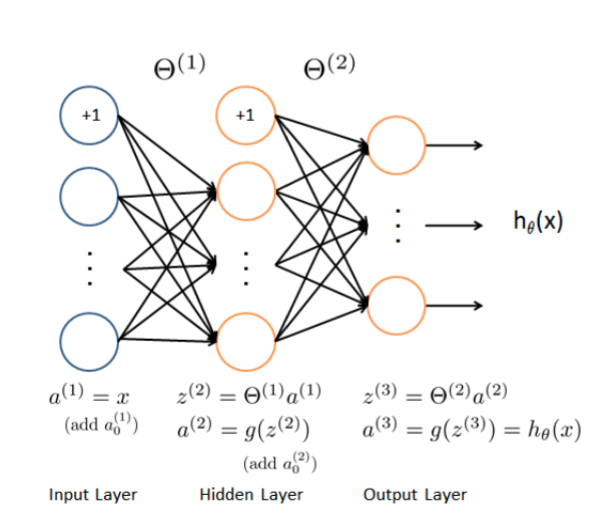